In [409]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.stats import pearsonr
import os
import csv
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple


In [410]:
# --- Configuraciones globales de matplotlib usando rcParams ---
plt.rcParams.update({
    # Ejes
    "axes.titlesize": 18,           # Tamaño título de los ejes (si usas ax.set_title)
    "axes.labelsize": 18,           # Tamaño etiquetas ejes (xlabel, ylabel)
    "xtick.labelsize": 18,          # Tamaño números eje x
    "ytick.labelsize": 18,          # Tamaño números eje y

    # Leyendas
    "legend.fontsize": 14,          # Tamaño texto leyendas
    "legend.title_fontsize": 15,    # Tamaño título leyendas

    # Colorbar
    "axes.labelweight": "normal",     # Peso (negrita) para etiquetas ejes
    "axes.titleweight": "normal",     # Peso (negrita) para título de ejes
    "legend.loc": 'best',           # Localización por defecto leyendas
    "figure.titlesize": 16,         # Tamaño título general figura (si hay)

    # Colorbar ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,


    "font.family": "serif",       # Use serif font
    "mathtext.fontset": "cm",     # Use Computer Modern for math
    "text.usetex": False          # Use mathtext, not full LaTeX
})


In [411]:
N = 200
nloop = 2000


cov_dir = "cov_matrices"
os.makedirs(cov_dir, exist_ok=True)
os.makedirs('dpr', exist_ok=True)
os.makedirs('figures', exist_ok=True)



In [412]:
v_rest = [-22, -17, -12.3, -8.5]
#pqif_vector = [0, 0.25, 0.5, 0.75, 1.0]
pqif_vector = [0, 0.25, 0.5, 0.75, 1]

In [ ]:
#Colors for plotting
v_rest = [-22, -17, -12.3, -8.5]
cmap = plt.cm.Reds
vrest_sorted = sorted(v_rest)
colors_sorted = [cmap(x) for x in np.linspace(0.25, 1, len(v_rest))]
color_map = {vr: c for vr, c in zip(vrest_sorted, colors_sorted)}

vrest_figures = [-17, -12.3]
figsize = (5,5)

In [414]:
# caculo D_PR con bias
def dpr_bias(ccorr, N, nloop):
    a = np.extract(np.identity(N), ccorr)
    c = np.extract(1-np.identity(N), ccorr)
    am2 = np.mean(a)**2
    astd2 = np.var(a)*N/(N-1)
    cm2 = np.mean(c)**2
    cstd2 = np.var(c)*N*(N-1)/(N*(N-1)-2)

    astd_bias2 = astd2*(nloop-1)/(nloop+1) - 2*(am2-cm2) / \
        (nloop-1) + 2*cstd2/(nloop+1)
    cstd_bias2 = (nloop-1)*cstd2/nloop - (am2-cm2)/nloop - \
        4*(cm2-np.sqrt(am2*cm2))/(nloop*(N+1))

    dpr_bias = N/(1+(astd_bias2/am2)+(N-1)*((cstd_bias2/am2)+(cm2/am2)))

    return dpr_bias, am2, cm2, astd2, cstd2

def dpr_model(r, r0):
    r = np.asarray(r)
    out = np.zeros_like(r)
    mask = r < r0
    out[mask] = (1 - (r[mask] / r0)**2)**2
    return out



In [415]:
gsyn_vect = np.logspace(np.log10(0.1), np.log10(25), num=30)

C:\Users\aceve\AppData\Local\Temp\ipykernel_2180\1083107380.py:66: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 3
  leg2 = ax.legend(handles=handles_dotted, labels=labels_colors, loc='lower right', bbox_to_anchor=(1,0), title='Gain')


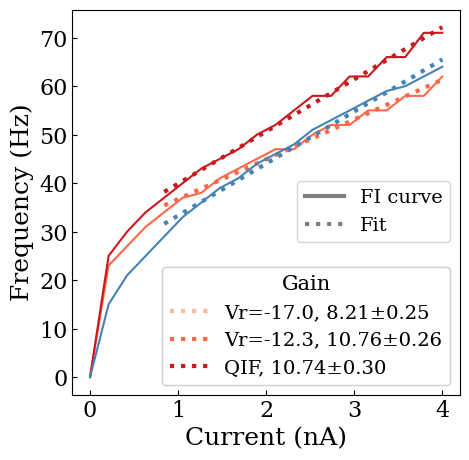

In [431]:
# Cargar datos
data = np.load('fi_data.npz', allow_pickle=True)
I_vals = data['I_vals']
v_rest = data['v_rest']
freqs_lif = data['freqs_lif'].item()  # dict
I_qif = data['I_qif']
freqs_qif = data['freqs_qif']

# Colores

vrest_sorted = sorted(v_rest)

fig, ax = plt.subplots(figsize=figsize)  # figura grande


# Graficar LIF
handles_dict = {}
labels_dict = {}
slopes_dict = {}

for vrest_value in vrest_sorted:
    freqs = freqs_lif[vrest_value]
    mask = I_vals > 0.7
    coef, cov = np.polyfit(I_vals[mask], freqs[mask], 1, cov=True)
    pendiente = coef[0]
    slopes_dict[vrest_value] = pendiente
    pendiente_err = np.sqrt(cov[0,0])
    
    
    if np.isin(vrest_value, vrest_figures):
        line, = ax.plot(I_vals, freqs, '-', color=color_map[vrest_value])
        ax.plot(I_vals[mask], np.polyval(coef, I_vals[mask]), ':', lw=3, color=color_map[vrest_value])
    
        handles_dict[vrest_value] = line
        labels_dict[vrest_value] = f"Vr={vrest_value}, {pendiente:.2f}±{pendiente_err:.2f}"

# Graficar QIF
mask_qif = I_qif > 0.7
coef_qif, cov_qif = np.polyfit(I_qif[mask_qif], freqs_qif[mask_qif], 1, cov=True)
pendiente_qif = coef_qif[0]
slopes_dict['QIF'] = pendiente_qif
pendiente_qif_err = np.sqrt(cov_qif[0,0])

line_qif, = ax.plot(I_qif, freqs_qif, '-', color='steelblue')
ax.plot(I_qif[mask_qif], np.polyval(coef_qif, I_qif[mask_qif]), ':', lw=3, color='steelblue')

handles_dict['QIF'] = line_qif
labels_dict['QIF'] = f"QIF, {pendiente_qif:.2f}±{pendiente_qif_err:.2f}"

# Ordenar handles y labels
handles_colors = [handles_dict[vr] for vr in vrest_figures] + [handles_dict['QIF']]
labels_colors = [labels_dict[vr] for vr in vrest_figures] + [labels_dict['QIF']]

# Labels ejes
ax.set_xlabel("Current (nA)")
ax.set_ylabel("Frequency (Hz)")
ax.tick_params(axis='both', direction='in')

# Leyenda FI y Fit
line_solid = mlines.Line2D([0],[0], color='gray', lw=3)
line_dotted = mlines.Line2D([0],[0], color='gray', lw=3, linestyle=':')
leg1 = ax.legend(handles=[line_solid, line_dotted], labels=['FI curve', 'Fit'], loc='lower right', bbox_to_anchor=(1,0.37))

# Leyenda de pendientes
handles_dotted = [mlines.Line2D([], [], color=color_map[vr], linestyle=':', lw=3) for vr in vrest_sorted] + [mlines.Line2D([], [], color='steelblue', linestyle=':', lw=3)]
leg2 = ax.legend(handles=handles_dotted, labels=labels_colors, loc='lower right', bbox_to_anchor=(1,0), title='Gain')

ax.add_artist(leg1)
ax.add_artist(leg2)

plt.savefig('figures/fi_curves_with_slopes.svg', dpi=300)
plt.show()


In [417]:
column_names = [ 'ipqif', 'gsyn', 'seed', 'dpr', 'am2', 'cm2', 'astd2', 'cstd2']
# Crear la carpeta dpr si no existe


for pqif in [0, 0.25, 0.5, 0.75, 1]:  # 0 -> LIF, 1 -> QIF, 0.5 -> MIX
    for vr in v_rest:

        vt = 0

        if vr == int(vr):
            vr = int(vr)

        if pqif == 1 and vr != v_rest[0]:
            continue
        if pqif == 1 and vr == v_rest[0]:
            
            vr = None
            vt = None


        filename = f'dpr/dpr_pqif_{pqif}_vt_{vt}_vrest_{vr}.csv'
       
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(column_names)
            
        for gsyn in [0.0] + list(gsyn_vect):
            
            for seed in range(15):
                # Sanitizar vrest y vt para nombre de archivo
                vrest_str = str(vr)
                vt_str = "0"  # asumiendo LIF para este ejemplo
                if pqif == 1:
                    vrest_str = "None"
                    vt_str = "None"
            
                fname = f"FASTER_cov_pqif_{pqif}_vt_{vt_str}_vrest_{vrest_str}_gsyn_{gsyn:.2f}_seed_{seed}.npy"

                fpath = os.path.join(cov_dir, fname)

                if os.path.exists(fpath):

                    ccorr = np.load(fpath)
                    dpr_b, am2, cm2, astd2, cstd2 = dpr_bias(ccorr, N, nloop)
    


                    with open(filename, mode='a', newline='') as file:
                        writer = csv.writer(file)
                        writer.writerow([pqif, gsyn, seed, dpr_b, am2, cm2, astd2, cstd2])

In [418]:
r0_dict = {}
r0_std_dict = {}
labels_dict = {}

# --- LIF ---
for vr in v_rest:
    if vr == int(vr):
        vr = int(vr)

    df = pd.read_csv(f"dpr/dpr_pqif_0_vt_0_vrest_{vr}.csv")
    
    df_grouped = df.groupby('gsyn').agg(
        dpr_mean=('dpr', 'mean'),
        dpr_std=('dpr', 'std')
    ).reset_index()
    
    R = df_grouped['gsyn'].values
    dpr_norm = df_grouped['dpr_mean'].values / 200
    dpr_std = df_grouped['dpr_std'].values / 200
    


    # Ajuste con pesos inversamente proporcionales a la varianza (sigma)
    popt, pcov = curve_fit(
        dpr_model, 
        R, 
        dpr_norm, 
        bounds=(2, 10)
    )
    
    # Error estándar del parámetro ajustado
    r0_std = np.sqrt(np.diag(pcov))[0]
    
    r0_dict[vr] = popt[0]
    r0_std_dict[vr] = r0_std
    labels_dict[vr] = f'Vr={vr}, r0={popt[0]:.2f}±{r0_std:.2f}'
    
    print(f"LIF vrest={vr} r0: {popt[0]:.2f} ± {r0_std:.2f}")
    

# --- QIF ---
df_qif = pd.read_csv('dpr/dpr_pqif_1_vt_None_vrest_None.csv')
df_grouped = df_qif.groupby('gsyn').agg(
    dpr_mean=('dpr', 'mean'),
    dpr_std=('dpr', 'std')
).reset_index()

R_qif = df_grouped['gsyn'].values
dpr_qif_norm = df_grouped['dpr_mean'].values / 200
dpr_qif_std = df_grouped['dpr_std'].values / 200

popt_qif, pcov_qif = curve_fit(
    dpr_model, 
    R_qif, 
    dpr_qif_norm,
    sigma=dpr_qif_std,
    absolute_sigma=True,
    bounds=(2, 10)
)

r0_std_qif = np.sqrt(np.diag(pcov_qif))[0]

r0_dict['QIF'] = popt_qif[0]
r0_std_dict['QIF'] = r0_std_qif
labels_dict['QIF'] = f'QIF, r0={popt_qif[0]:.2f}±{r0_std_qif:.2f}'

print(f"QIF r0: {popt_qif[0]:.2f} ± {r0_std_qif:.2f}")


LIF vrest=-22 r0: 8.06 ± 0.22
LIF vrest=-12.3 r0: 5.68 ± 0.10
LIF vrest=-17 r0: 6.89 ± 0.15
LIF vrest=-8.5 r0: 4.56 ± 0.07
QIF r0: 5.96 ± 0.03


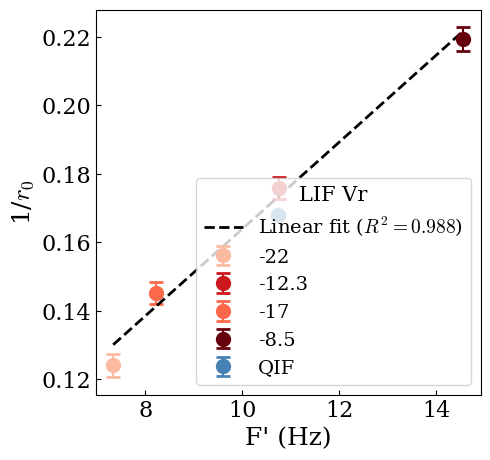

In [434]:
# --- Gráfico ---
fig, ax = plt.subplots(figsize=figsize)  # figura grande
ax.set_box_aspect(1)

# Recopilar datos para el ajuste lineal
gains_all = []
inv_r0_all = []
inv_r0_err_all = []

# Conectar puntos LIF
for vr in v_rest:
    # Calcular error propagado para 1/r0
    # Si y = 1/x, entonces σ_y = σ_x / x²
    r0_val = r0_dict[vr]
    r0_err = r0_std_dict[vr]
    inv_r0_err = r0_err / (r0_val**2)

    if vr == int(vr):
        vr = int(vr)
    
    # Guardar datos para el ajuste
    gains_all.append(slopes_dict[vr])
    inv_r0_all.append(1/r0_val)
    inv_r0_err_all.append(inv_r0_err)
    
    ax.errorbar(
        slopes_dict[vr], 
        1/r0_val, 
        yerr=inv_r0_err,
        fmt='o',
        color=color_map[vr], 
        label=f'{vr}',
        capsize=5,
        capthick=2,
        markersize=10
    )

# Ajuste lineal
gains_all = np.array(gains_all)
inv_r0_all = np.array(inv_r0_all)
inv_r0_err_all = np.array(inv_r0_err_all)

# Ajuste lineal ponderado por errores
weights = 1 / inv_r0_err_all**2
pfit = np.polyfit(gains_all, inv_r0_all, 1, w=weights)
slope_fit, intercept_fit = pfit

# Calcular R²
inv_r0_pred = slope_fit * gains_all + intercept_fit
ss_res = np.sum((inv_r0_all - inv_r0_pred)**2)
ss_tot = np.sum((inv_r0_all - np.mean(inv_r0_all))**2)
r_squared = 1 - (ss_res / ss_tot)

# Generar línea de ajuste
gains_fit = np.linspace(gains_all.min(), gains_all.max(), 100)
inv_r0_fit = slope_fit * gains_fit + intercept_fit

# Graficar ajuste
ax.plot(gains_fit, inv_r0_fit, 'k--', linewidth=2, 
        label=f'Linear fit ($R^2 = {r_squared:.3f}$)')

ax.legend()

# QIF
r0_qif = r0_dict['QIF']
r0_qif_err = r0_std_dict['QIF']
inv_r0_qif_err = r0_qif_err / (r0_qif**2)

ax.errorbar(
    slopes_dict['QIF'], 
    1/r0_qif, 
    yerr=inv_r0_qif_err,
    fmt='o',
    color='steelblue', 
    label='QIF',
    capsize=5,
    capthick=2,
    markersize=10
)

# Labels
ax.legend(title='LIF Vr', loc='lower right')
ax.set_xlabel("F' (Hz)")
ax.set_ylabel(r'1/$r_0$')

plt.savefig('figures/slope_vs_inv_r0.svg', dpi=300)
plt.show()




[ 0.1         0.12097276  0.14634408  0.17703648  0.21416591  0.25908241
  0.31341914  0.37915179  0.45867038  0.55486621  0.67123696  0.81201388
  0.98231559  1.18833428  1.43756076  1.73905692  2.10378514  2.54500694
  3.07876512  3.72446711  4.50559063  5.45053731  6.59366537  7.97653894
  9.64943925 11.67319291 14.12138355 17.08302733 20.66580952 25.        ]
[ 0.1         0.12097276  0.14634408  0.17703648  0.21416591  0.25908241
  0.31341914  0.37915179  0.45867038  0.55486621  0.67123696  0.81201388
  0.98231559  1.18833428  1.43756076  1.73905692  2.10378514  2.54500694
  3.07876512  3.72446711  4.50559063  5.45053731  6.59366537  7.97653894
  9.64943925 11.67319291 14.12138355 17.08302733 20.66580952 25.        ]


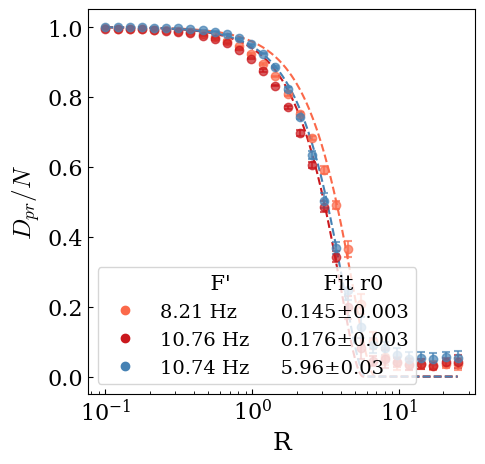

In [420]:
fig, ax = plt.subplots(figsize=figsize)  # figura grande


for vr in vrest_figures:  # usar ordenado
    if vr == int(vr):
        vr = int(vr)

    df = pd.read_csv(f"dpr/dpr_pqif_0_vt_0_vrest_{vr}.csv")

    df_grouped = df.groupby('gsyn').agg(
        dpr_mean=('dpr', 'mean'),
        dpr_std=('dpr', 'std')
    ).reset_index()

    R = df_grouped['gsyn'].values[1:]  # Evitar R=0
    print(R)
    dpr_mean = df_grouped['dpr_mean'].values[1:] / 200
    dpr_std = df_grouped['dpr_std'].values[1:] / 200  # ← Ahora sí se usa

    R_fit = np.linspace(min(R), max(R), 300)
    
    # Agregar barras de error
    ax.errorbar(R, dpr_mean, yerr=dpr_std, 
                fmt='o', color=color_map[vr],
                capsize=3, capthick=1.5, 
                elinewidth=1.5, alpha=0.7)
    
    ax.plot(R_fit, dpr_model(R_fit, r0_dict[vr]), '--', color=color_map[vr],
            label=f'F$\'=$ {slopes_dict[vr]:.2f} Hz, r0={r0_dict[vr]:.2f}±{r0_std_dict[vr]:.2f}')


# QIF con barras de error
ax.errorbar(R_qif, dpr_qif_norm, yerr=dpr_qif_std,
            fmt='o', color='steelblue',
            capsize=3, capthick=1.5, 
            elinewidth=1.5, alpha=0.7)

ax.plot(R_fit, dpr_model(R_fit, r0_dict['QIF']), '--', color='steelblue',
         label=f'QIF, F$\'=$ {slopes_dict["QIF"]:.2f} Hz, r0={r0_dict["QIF"]:.2f}±{r0_std_dict["QIF"]:.2f}')

ax.set_xlabel('R')
ax.set_ylabel(r'$D_{pr}/N$')
ax.set_xscale('log')


# --- Crear filas como tuplas (F', línea, r0) ---
legend_handles = []
legend_labels = []

for vr in vrest_figures:
    color = color_map[vr]
    h_Fp = Line2D([0], [0], linestyle='None', color='none', marker=None)
    h_line = Line2D([0], [0], color=color, marker='o', linestyle='--')
    h_r0 = Line2D([0], [0], linestyle='None', color='none', marker=None)
    legend_handles.append((h_Fp, h_line, h_r0))

    r0_val = r0_dict[vr]
    r0_err = r0_std_dict[vr]
    inv_r0 = 1 / r0_val
    inv_r0_err = r0_err / (r0_val**2)  # Error propagado para 1/r0
    
    if slopes_dict[vr] >= 10:
        legend_labels.append(f"{slopes_dict[vr]:.2f} Hz  {''}   {inv_r0:.3f}±{inv_r0_err:.3f}")
    else:
        legend_labels.append(f"{slopes_dict[vr]:.2f} Hz   {' '}   {inv_r0:.3f}±{inv_r0_err:.3f}")
# Agregar QIF
color = 'steelblue'
h_Fp = Line2D([0], [0], linestyle='None', color='none', marker=None)
h_line = Line2D([0], [0], color=color, marker='o', linestyle='--')
h_r0 = Line2D([0], [0], linestyle='None', color='none', marker=None)
legend_handles.append((h_Fp, h_line, h_r0))
legend_labels.append(f"{slopes_dict['QIF']:.2f} Hz  {''}   {r0_dict['QIF']:.2f}±{r0_std_dict['QIF']:.2f}")

# --- Crear la leyenda con HandlerTuple ---
ax.legend(legend_handles, legend_labels,
          handler_map={tuple: HandlerTuple(ndivide=None)},
          loc='lower left',
          title="            F'              Fit r0",
          frameon=True)

plt.savefig('figures/dpr_fits_with_legend.svg', dpi=300)
plt.show()

In [421]:
cmap_pqif = plt.cm.Greens
colors_all_pqif = [cmap_pqif(x) for x in np.linspace(0.25, 1, 3)]
colors_all_pqif = [color] + colors_all_pqif + ['steelblue']
color_map_pqif = {pqif_m: c for pqif_m, c in zip(pqif_vector, colors_all_pqif)}
print(color_map_pqif)

{0: 'steelblue', 0.25: (np.float64(0.7792233756247597), np.float64(0.9132333717800846), np.float64(0.7518031526336024), np.float64(1.0)), 0.5: (np.float64(0.25259515570934254), np.float64(0.6681276432141483), np.float64(0.3628604382929642), np.float64(1.0)), 0.75: (np.float64(0.0), np.float64(0.26666666666666666), np.float64(0.10588235294117647), np.float64(1.0)), 1: 'steelblue'}


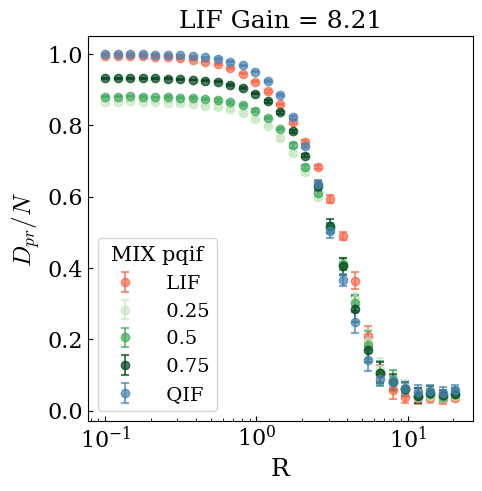

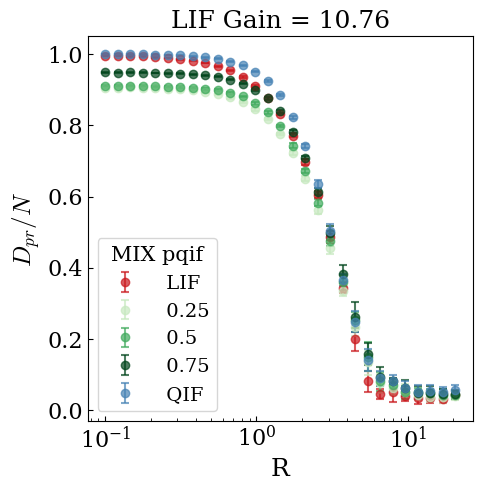

In [432]:
# --- Configuración ---


for vr in vrest_figures: 
    if vr == int(vr):
        vr = int(vr)
    color =  color_map[vr]

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_box_aspect(1)
    pqif_mix = [0, 0.25, 0.5, 0.75, 1]

    # LIF para vrests_fig2
    for pqif in pqif_mix:  # usar ordenado
        if pqif == 0:
            color = color_map[vr]
        if pqif != 0:
            color = color_map_pqif[pqif]
        if pqif != 1:
            
            df = pd.read_csv(f"dpr/dpr_pqif_{pqif}_vt_0_vrest_{vr}.csv")
        if pqif==1:
            df = pd.read_csv(f"dpr/dpr_pqif_1_vt_None_vrest_None.csv")

        df_grouped = df.groupby('gsyn').agg(
            dpr_mean=('dpr', 'mean'),
            dpr_std=('dpr', 'std')
        ).reset_index()


        df_grouped = df_grouped[df_grouped['gsyn'] <= 25]
        R = df_grouped['gsyn'].values
        dpr_mean = df_grouped['dpr_mean'].values / N
        dpr_std = df_grouped['dpr_std'].values / N


        if pqif == 0:
            label = f' LIF'
        elif pqif == 1:
            label = ' QIF'
        else:
            label = f' {pqif}'
        
        ax.errorbar(R, dpr_mean, yerr=dpr_std, 
                    fmt='o', color=color,
                    capsize=3, capthick=1.5, 
                    elinewidth=1.5, alpha=0.7, label = label)
        


    ax.set_xlabel('R')
    ax.set_ylabel(r'$D_{pr}/N$')


    ax.set_xscale('log')
    ax.legend(title=r'MIX pqif', loc ='lower left')
    ax.set_title(f'LIF Gain = {slopes_dict[vr]:.2f}')
    plt.savefig(f'figures/mix_dpr_vrest_{vr}.svg', dpi=300)

    plt.show()

-17


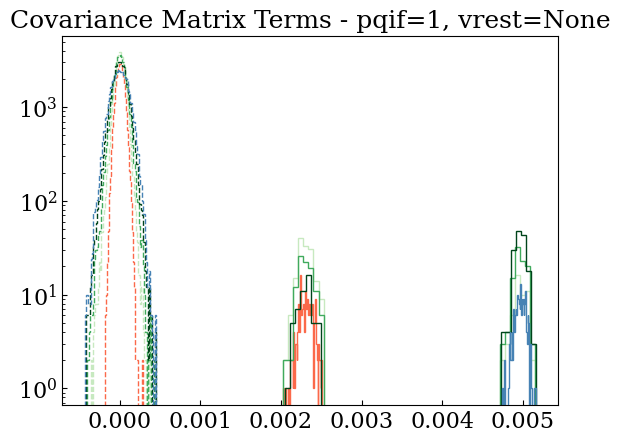

-17


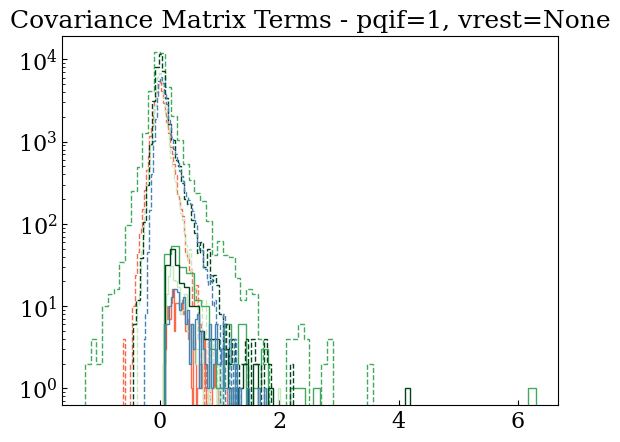

In [423]:
for gsyn in [0, gsyn_vect[-1]]:
    for vr in [-17]:
        vt = 0
        for pqif in [0, 0.25, 0.5, 0.75, 1]:
            if vr == int(vr):
                vr = int(vr)
            if pqif ==1:
                vr = None
                vt = None
                color = 'steelblue'
            if pqif ==0:
                print( vr)
                color = color_map[vr]
            else:
                color = color_map_pqif[pqif]
            
            matrix_path = f"cov_matrices/FASTER_cov_pqif_{pqif}_vt_{vt}_vrest_{vr}_gsyn_{gsyn:.2f}_seed_0.npy"
            matrix = np.load(matrix_path)
            

            diag_terms = np.diag(matrix)
            non_diag_terms = matrix[~np.eye(matrix.shape[0],dtype=bool)]

            mean_diag = np.mean(diag_terms)
            mean_non_diag = np.mean(non_diag_terms)

            std_diag = np.std(diag_terms)
            std_non_diag = np.std(non_diag_terms)

            plt.hist(diag_terms, bins=50, label='Diagonal terms', color=color, linestyle='solid', histtype='step')
            plt.hist(non_diag_terms, bins=50, label='Non-diagonal terms', color=color, linestyle='dashed', histtype='step')
            #plt.axvline(mean_diag, color=color, linestyle='dashed', linewidth=1
            #, label=f'Diag Mean: {mean_diag:.2f} ± {std_diag:.2f}')
            #plt.axvline(mean_non_diag, color='orange', linestyle='dashed', linewidth=1
            #, label=f'Non-Diag Mean: {mean_non_diag:.2f} ± {std_non_diag:.2f}')
            plt.yscale('log')
            plt.title(f'Covariance Matrix Terms - pqif={pqif}, vrest={vr}')
        plt.show()

{-22: (np.float64(0.9882352941176471), np.float64(0.732072279892349), np.float64(0.6299269511726259), np.float64(1.0)), -17: (np.float64(0.9835755478662053), np.float64(0.4127950788158401), np.float64(0.28835063437139563), np.float64(1.0)), -12.3: (np.float64(0.7925720876585928), np.float64(0.09328719723183392), np.float64(0.11298731257208766), np.float64(1.0)), -8.5: (np.float64(0.403921568627451), np.float64(0.0), np.float64(0.05098039215686274), np.float64(1.0))}


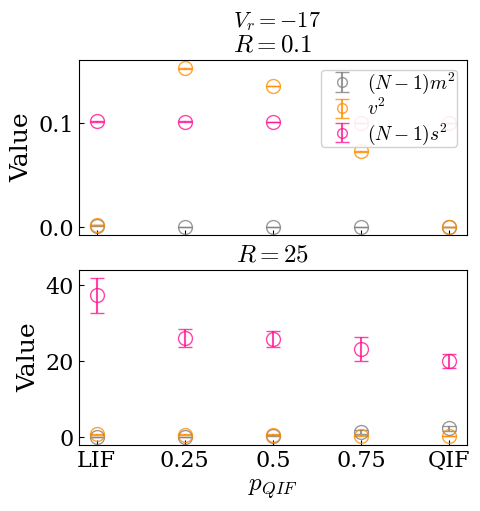

In [424]:
# Crear figura con 2 subplots verticales
fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
ax.set_box_aspect(1)

print(color_map )
fig.suptitle('   $V_r = -17$')

for idx, gsyn in enumerate([gsyn_vect[0], gsyn_vect[-1]]):
    ax = axes[idx]

    for pqif in [0, 0.25, 0.5, 0.75, 1]:
        vr = -17
        vt = 0
        if pqif == 1:
            vr = None
            vt = None
            color = 'steelblue'
        if pqif == 0:
            
            color = color_map[vr]
        else:
            color = color_map_pqif[pqif]
        
        v_vect = []
        m_vect = []
        s_vect = []
        
        for seed in range(20):
            matrix_path = f"cov_matrices/FASTER_cov_pqif_{pqif}_vt_{vt}_vrest_{vr}_gsyn_{gsyn:.2f}_seed_{seed}.npy"
            matrix = np.load(matrix_path)
            diag_terms = np.diag(matrix)
            non_diag_terms = matrix[~np.eye(matrix.shape[0], dtype=bool)]
            mean_diag = np.mean(diag_terms)
            mean_non_diag = np.mean(non_diag_terms)
            std_diag = np.std(diag_terms)
            std_non_diag = np.std(non_diag_terms)
            v = std_diag / mean_diag
            m = mean_non_diag / mean_diag
            s = std_non_diag / mean_diag
            
            v_vect.append(v)
            m_vect.append(m)
            s_vect.append(s)
        
        # Convertir a arrays numpy
        v_vect = np.array(v_vect)
        m_vect = np.array(m_vect)
        s_vect = np.array(s_vect)
        
        # Calcular las cantidades transformadas para cada semilla
        v_squared = v_vect**2
        m_scaled = (N - 1) * (m_vect**2)
        s_scaled = (N - 1) * (s_vect**2)
        
        # Calcular media y error estándar
        v_mean = np.mean(v_squared)
        v_sem = np.std(v_squared) / np.sqrt(len(v_squared))
        
        m_mean = np.mean(m_scaled)
        m_sem = np.std(m_scaled) / np.sqrt(len(m_scaled))
        
        s_mean = np.mean(s_scaled)
        s_sem = np.std(s_scaled) / np.sqrt(len(s_scaled))
        
        # Graficar con barras de error
        # Solo mostrar label en el primer subplot
        show_label = (idx == 0 and pqif == 0)
        ax.errorbar(pqif, m_mean, yerr=m_sem, fmt='o', color='gray', alpha = 0.8, capsize=5, 
                    markerfacecolor = 'none', markersize = 10, label='$(N-1)m^2$' if show_label else '')

        ax.errorbar(pqif, v_mean, yerr=v_sem, fmt='o', color='darkorange', alpha = 0.8,capsize=5, 
                    markerfacecolor = 'none', markersize = 10, label='$v^2$' if show_label else '')

        ax.errorbar(pqif, s_mean, yerr=s_sem, fmt='o', color='deeppink', alpha = 0.8, capsize=5, 
                    markerfacecolor = 'none', markersize = 10, label='$(N-1)s^2$' if show_label else '')

    # Configurar cada subplot
    ax.set_ylabel('Value')
    if gsyn == gsyn_vect[0]:
        g = 0.1
    else:
        g = 25
    ax.set_title(f'$R = {g}$')


# Leyenda solo en el primer subplot
    if idx == 0:
        ax.legend(loc='upper right', framealpha=0.9, labelspacing=0.1, 
                 handletextpad=0.3, borderpad=0.05, markerscale=0.7)
    # Configurar eje x compartido (solo aparece abajo)
    axes[-1].set_xlabel('$p_{QIF}$')

    # Configurar xticks personalizados
    pqif_values = [0, 0.25, 0.5, 0.75, 1]
    tick_labels = ['LIF', '0.25', '0.5', '0.75', 'QIF']
    axes[-1].set_xticks(pqif_values)
    axes[-1].set_xticklabels(tick_labels)

plt.savefig('figures/variance_components_vs_pqif_vrest_-17.svg', dpi=300)

plt.show()